<a href="https://colab.research.google.com/github/darrenjhsu/birdid/blob/master/Bird_ID_make_img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
datapath = '/content/gdrive/My Drive/Bird_ID_project/nabirds'

In [0]:
!ls /content/gdrive/My\ Drive/Bird_ID_project/nabirds

bounding_boxes.txt	images		   README
classes2.txt		images.txt	   README~
classes.txt		__init__.py	   sizes.txt
data			nabirds.py	   train_test_split.txt
hierarchy.txt		parts
image_class_labels.txt	photographers.txt


In [0]:
if __name__ == '__main__':
    # Read files
    file_dir = '/content/gdrive/My Drive/Bird_ID_project/nabirds/'
    images = pd.read_csv(file_dir + 'images.txt', sep=" ", header=None, names = ["image_id","image_name"])
    print(images)
    #imagesFrame = pd.DataFrame([images], columns = )
    print("read image")
    train_test_split = pd.read_csv(file_dir + 'train_test_split.txt', sep=" ", header=None, names = ["image_id","is_training"])
    #trainTestSplitFrame = pd.DataFrame([train_test_split],columns = )
    print("read split")
    image_size = pd.read_csv(file_dir + 'sizes.txt', sep=" ", header=None, names = ["image_id","image_width","image_height"])
    #imageSizeFrame = pd.DataFrame([bounding_box],column )
    print("read image size")
    classes = pd.read_csv(file_dir + 'classes2.txt', sep=" ", header=None, names = ["class_id", "class_name"])
    #classesFrame = pd.DataFrame([classes],columns)
    print("read classes")
    image_class_label = pd.read_csv(file_dir + 'image_class_labels.txt', sep=" ", header=None, names = ["image_id","class_id"])
    #imageClassLabelFrame = pd.DataFrame([image_class_label],columns)
    print("read image class label")
    hierarchy = pd.read_csv(file_dir + 'hierarchy.txt', sep=" ", header=None, names = ["child_class_id","parent_class_id"])
    #hierarchyFrame = pd.DataFrame([hierarchy],columns)
    print("read hierarchy")    
    bounding_box = pd.read_csv(file_dir + 'bounding_boxes.txt', sep=" ", header=None, names = ["image_id","bb_x","bb_y","bb_width","bb_height"])
    #boundingBoxFrame = pd.DataFrame([bounding_box],column = ["image_id","bb_x","bb_y","bb_width","bb_height"])
    print("read bounding boxes")
    
    
    #print(classes)
    
    # Concatenate to a full frame including
    # ['image name','class id','x','y','x_end ( = x + x_dim)','y_end']
    # 
    
    img_bbox = pd.merge(images, bounding_box, on="image_id")
    img_class_bbox = pd.merge(img_bbox,image_class_label,on="image_id")
    full_frame = pd.merge(img_class_bbox,classes,on="class_id")
    
    print(full_frame)
    

                                   image_id  \
0      0000139e-21dc-4d0c-bfe1-4cae3c85c829   
1      0000d9fc-4e02-4c06-a0af-a55cfb16b12b   
2      00019306-9d83-4334-b255-a447742edce3   
3      0001afd4-99a1-4a67-b940-d419413e23b3   
4      000332b8-997c-4540-9647-2f0a8495aecf   
5      000343bd-5215-49ba-ab9c-7c97a70ac1a5   
6      0004ff8d-0cc8-47ee-94ba-43352a8b9eb4   
7      0007181f-a727-4481-ad89-591200c61b9d   
8      00071e20-8156-4bd8-b5ca-6445c2560ee5   
9      0007acfc-c0e6-4393-9ab6-02215a82ef63   
10     00081fce-2a74-4a9f-b52b-9bb8871a48e2   
11     00085a7b-efcc-4c08-a830-38477e749101   
12     0009051b-a76c-4a27-ac5d-bf410aea7e0c   
13     000948ee-8c19-40bb-8403-72c665e7ffc3   
14     00098273-c636-4b0e-b615-b6c03b00d39a   
15     000c3c44-dd8c-4efe-949e-3adfd766d719   
16     000d5736-1eff-4207-a587-7b8f7115d529   
17     000ef8cc-7230-46a0-8415-e13eb13bbc28   
18     001037a2-b6d1-4517-b305-c14a8bdf7963   
19     00114d1f-8049-4003-8517-4449acd06059   
20     0013bc

0824/ff00f70597e54ff693a4e9b08257ded7.jpg


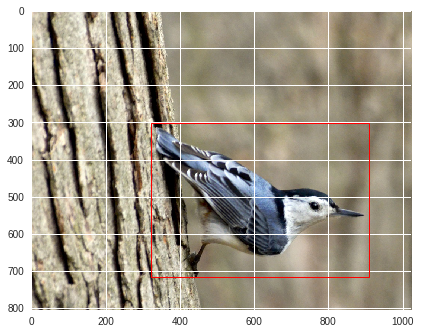

In [0]:
if __name__ == '__main__':
    WBNH = full_frame[full_frame['class_name'] == 'White-breasted_Nuthatch']
    NCAM = full_frame[full_frame['class_name'] == 'Northern_Cardinal_(Adult_Male)']
    
    for index, row in WBNH.iterrows():
        if (index == 29669):
            print(row['image_name'])
            img = file_dir + 'images/' + row['image_name']
#            print(img)
            fig,ax = plt.subplots(1)
            image = plt.imread(img)
            plt.imshow(image)
            rect = patches.Rectangle((row['bb_x'],row['bb_y']),row['bb_width'],row['bb_height'],linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
#            plt.imshow(img)
            plt.show()

In [0]:
def make_npy_2(df, bird1, bird2, y_path, X_path):
    print(y_path)
    df = df[(df['class_name']==bird1) | (df['class_name']==bird2)]
    #print(df)
    var = df.iloc[0]['class_id']
    df['class_id_2'] = df['class_id'].apply(lambda x: 1 if x == var else 0)
    #print(df)
    print('Bird class = 1: ', df.iloc[0]['image_name'])
    print('Bird class = 0: ', df.iloc[-1]['image_name'])
    target = df['class_id_2'].values
    np.save(y_path, target)
    print(target)
    zipper = zip(df.image_name, df.bb_y, df.bb_height, df.bb_x, df.bb_width)
    new_x = []
    for i, z in enumerate(zipper):
        print(datapath + '/images/' + z[0])
        image = cv2.imread(datapath + '/images/' + z[0])
        cropped = image[z[1]:(z[1]+z[2]), z[3]:(z[3]+z[4])]
        new_x.append(paint_to_square(cropped, z)/255.0)
        print(i)
        if (i < 10):
            print(image.shape)
            print(cropped.shape)
            cropped = paint_to_square(cropped, z)
            fig,ax = plt.subplots(1)
            #plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
            plt.imshow(cropped)
            plt.show()

    X = np.array(new_x)
    np.save(X_path, X)
    return target, X
    
    
def make_npy_many(df, bird_list, y_path, X_path, L_path):
    # y_path = ground truth label
    # X_path = data
    print(y_path)
#     df = df[(df['class_name']==bird1) | (df['class_name']==bird2)]
    df = df[df['class_name'].isin(bird_list)]
    df['class_id_2'] = pd.Series(np.zeros(len(df)), index=df.index)
#     print(df)
    var = df.class_id.unique()
    print(var)
    for i, z in enumerate(var):
        df.loc[df['class_id']==z,'class_id_2'] = i
#         print(df[df['class_id']==z])
#     print(df)
        print('Now processing bird class = {}: {} '.format(i,df.loc[df['class_id']==z,'class_name'].iloc[0]))
#     print('Bird class = 0: ', df.iloc[-1]['image_name'])
    target = df['class_id_2'].values.astype(int)
    np.save(y_path, target)
#     print(target)
    zipper = zip(df.image_name, df.bb_y, df.bb_height, df.bb_x, df.bb_width)
    new_x = []
    for i, z in enumerate(zipper):
        print(datapath + '/images/' + z[0])
        image = cv2.imread(datapath + '/images/' + z[0])
        cropped = image[z[1]:(z[1]+z[2]), z[3]:(z[3]+z[4])]
        new_x.append(paint_to_square(cropped, z)/255.0)
        print(i)
        if (i < 10):
            print(image.shape)
            print(cropped.shape)
            cropped = paint_to_square(cropped, z)
            fig,ax = plt.subplots(1)
            #plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
            plt.imshow(cropped)
            plt.show()

    X = np.array(new_x)
    np.save(X_path, X)
    
    np.save(L_path, bird_list)
    
    return target, X


def paint_to_square(img, z):
    desired_size = 224
    old_size = img.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    new_im = cv2.cvtColor(new_im, cv2.COLOR_BGR2RGB)
    return new_im

In [0]:
y, X = make_npy_many(full_frame, ['Osprey','White-breasted_Nuthatch', 'Northern_Cardinal_(Adult_Male)'],datapath + '/data/y_3.npy', datapath + '/data/X_3.npy')
#make_npy(df, 'Black_Throated_Sparrow', 'Harris_Sparrow', )

In [0]:
full_frame.loc[full_frame['class_id']==814,'class_name'].iloc[0]

'Chestnut-backed_Chickadee'

In [0]:
Bird_list=full_frame[full_frame['class_id'].isin((full_frame.class_id.value_counts()==120).index[:25].tolist())].class_name.unique()
print(Bird_list)
print(len(Bird_list))

['Red-eyed_Vireo' "Steller's_Jay" 'Wild_Turkey' 'Western_Meadowlark'
 'Gray_Catbird' 'House_Finch_(Adult_Male)'
 'Northern_Cardinal_(Female/Juvenile)' 'Common_Yellowthroat_(Adult_Male)'
 'Black-throated_Green_Warbler' 'Brown-headed_Cowbird_(Male)'
 'American_Coot' "Wilson's_Warbler" 'Northern_Harrier_(Female,_immature)'
 'Northern_Mockingbird' 'Ring-billed_Gull_(Adult)' 'Hermit_Thrush'
 'Prairie_Warbler' 'American_Kestrel_(Adult_male)' 'Bushtit'
 'Mourning_Dove' "Cooper's_Hawk_(Immature)" 'Downy_Woodpecker'
 'Tufted_Titmouse' 'Great-tailed_Grackle' "Townsend's_Warbler"]
25


/content/gdrive/My Drive/Bird_ID_project/nabirds/data/y_30.npy
[947 949 469 910 851 790 979 756 883 783 501 885 655 852 397 848 879 363
 822 529 657 559 819 914 881]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Now processing bird class = 0: Red-eyed_Vireo 
Now processing bird class = 1: Steller's_Jay 
Now processing bird class = 2: Wild_Turkey 
Now processing bird class = 3: Western_Meadowlark 
Now processing bird class = 4: Gray_Catbird 
Now processing bird class = 5: House_Finch_(Adult_Male) 
Now processing bird class = 6: Northern_Cardinal_(Female/Juvenile) 
Now processing bird class = 7: Common_Yellowthroat_(Adult_Male) 
Now processing bird class = 8: Black-throated_Green_Warbler 
Now processing bird class = 9: Brown-headed_Cowbird_(Male) 
Now processing bird class = 10: American_Coot 
Now processing bird class = 11: Wilson's_Warbler 
Now processing bird class = 12: Northern_Harrier_(Female,_immature) 
Now processing bird class = 13: Northern_Mockingbird 
Now processing bird class = 14: Ring-billed_Gull_(Adult) 
Now processing bird class = 15: Hermit_Thrush 
Now processing bird class = 16: Prairie_Warbler 
Now processing bird class = 17: American_Kestrel_(Adult_male) 
Now processing bird

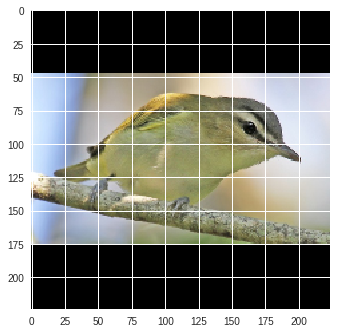

/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/00703a2f095e422b9cb187a092f3efc9.jpg
1
(683, 1024, 3)
(452, 522, 3)


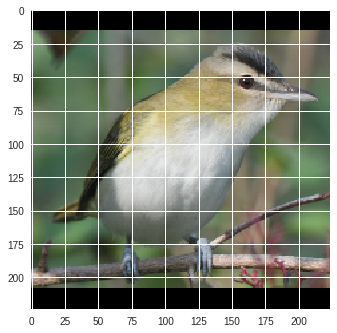

/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/00945ae724554a1aae98dc7c06d1c281.jpg
2
(641, 800, 3)
(306, 445, 3)


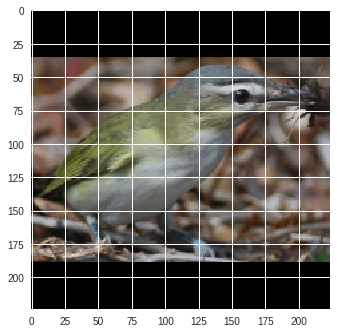

/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/02484222049e4e92812f86e0543e7e5f.jpg
3
(640, 800, 3)
(247, 365, 3)


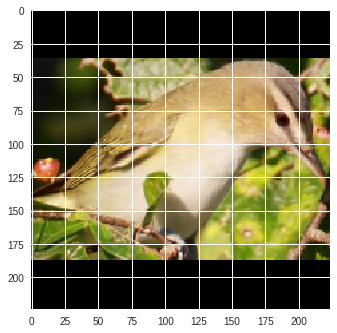

/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/03fd102cb64746279f59b32adb356846.jpg
4
(562, 700, 3)
(464, 640, 3)


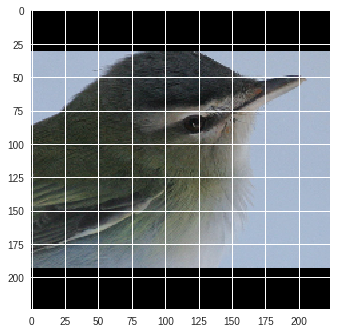

/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/0cf1b889423d4dbaa2efcf3aa008dd97.jpg
5
(805, 1024, 3)
(410, 592, 3)


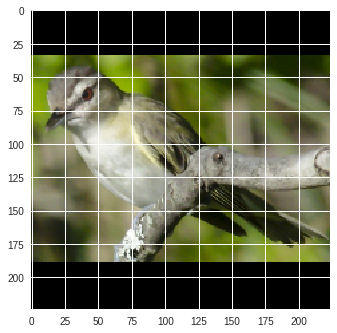

/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/0ef170e1020f453e868b8a9b223a2505.jpg
6
(900, 600, 3)
(377, 210, 3)


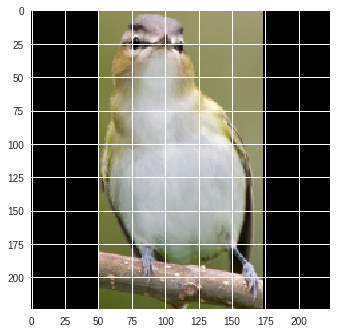

/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/0f19a5f5f687437c83b3faf21b5b0703.jpg
7
(793, 1024, 3)
(543, 858, 3)


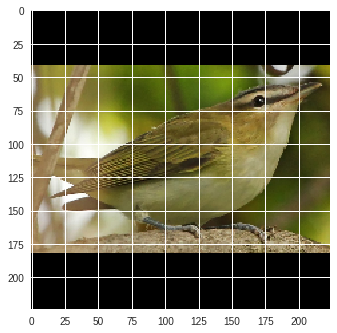

/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/140ca020f5964c35b6d0215075a3fda5.jpg
8
(784, 1024, 3)
(302, 363, 3)


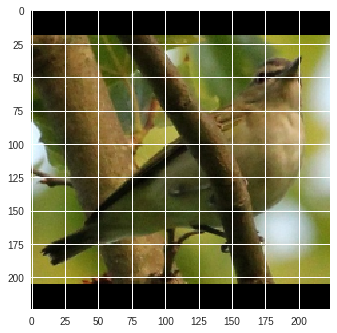

/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/191015ac22ca428b93dc3ca4f22d0bb5.jpg
9
(681, 1024, 3)
(337, 319, 3)


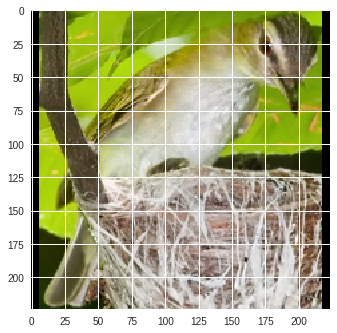

/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/19b0f7d1f72d49eca7ae4faea2ca2e4b.jpg
10
/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/1cd4551e33304c85a8bbcbcabc5d1f05.jpg
11
/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/1ecfebe17a7f4ec28eac2da5c47dbece.jpg
12
/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/1fbdb7a47c894ff4973feac950801755.jpg
13
/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/229819cb8a59496fa35233b2f8e4fac0.jpg
14
/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/22fddd7a547440f3810ac7b4dadecf31.jpg
15
/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/241c5c296142465a921199f5b67a762e.jpg
16
/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/268b01fb830e4cac9fc4b9133064f061.jpg
17
/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/298453a8e33146719ab271d35d9a9b12.jpg
18
/content/gdrive/My Drive/Bird_ID_project/nabirds/images/0947/2e695e57f363443ab6efe3285570ea

In [0]:
y, X = make_npy_many(full_frame, Bird_list,datapath + '/data/y_30.npy', datapath + '/data/X_30.npy', datapath + '/data/L_30.npy')
#make_npy(df, 'Black_Throated_Sparrow', 'Harris_Sparrow', )

# 3/22 TODO: 
1.  Prepare the input file as square
1.  Run CNN transfer learning (with MobilV2?) with WBNH and NCAM
1.  Run fine tuning





In [0]:
!ls /content/gdrive/My\ Drive/Bird_ID_project/nabirds/data

L_20.npy  X_Northern_Cardinal_Adult_Male.npy  y_White-breasted_Nuthatch.npy
X_20.npy  y_20.npy
X_3.npy   y_3.npy
